In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
with open('data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [4]:
df = pd.read_csv(f"data/processed/spectrometry_photometry.csv")

X = df[spectro_cols + photo_cols + generic_cols]
y = df[target_col]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
input_shape = X_train_scaled.shape[1]

full_input = keras.Input(shape=(input_shape,), name='full_input')
x = layers.Dense(128, activation='relu', name='layer1_Dense128')(full_input)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu', name='layer2_Dense256')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu', name='layer3_Dense512')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu', name='layer4_Dense256')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', name='layer5_Dense128')(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(1, name='logM_star')(x)

model = keras.Model(inputs=full_input, outputs=output, name='SpecPhoto_Model_v1.0')
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "SpecPhoto_Model_v1.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 full_input (InputLayer)     [(None, 58)]              0         
                                                                 
 layer1_Dense128 (Dense)     (None, 128)               7552      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 layer2_Dense256 (Dense)     (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 layer3_Dense512 (Dense)     (None, 512)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 512)      

In [8]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, epochs=500, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])

Epoch 1/500
6093/6093 [==============================] - 37s 6ms/step - loss: 4495486.0000 - mae: 406.2433 - mse: 4495486.0000 - mape: 1288.8298 - val_loss: 1586413.1250 - val_mae: 222.6422 - val_mse: 1586413.1250 - val_mape: 384.2510
Epoch 2/500
6093/6093 [==============================] - 35s 6ms/step - loss: 1117817.5000 - mae: 255.8763 - mse: 1117817.5000 - mape: 624.0081 - val_loss: 722047.1250 - val_mae: 139.9430 - val_mse: 722047.1250 - val_mape: 311.4030
Epoch 3/500
6093/6093 [==============================] - 35s 6ms/step - loss: 817443.2500 - mae: 212.3775 - mse: 817443.2500 - mape: 487.4455 - val_loss: 1244250.0000 - val_mae: 123.7415 - val_mse: 1244250.0000 - val_mape: 515.2200
Epoch 4/500
6093/6093 [==============================] - 36s 6ms/step - loss: 930986.9375 - mae: 198.9596 - mse: 930986.9375 - mape: 429.9934 - val_loss: 1505215.1250 - val_mae: 135.0197 - val_mse: 1505215.1250 - val_mape: 510.5928
Epoch 5/500
6093/6093 [==============================] - 35s 6ms/step

In [9]:
# Save weights from the trained model
model.save_weights('models/spec_photo_model_v1.0.h5')

In [10]:
y_pred_full = model.predict(X_test_scaled)

# Evaluate accuracy metrics
mae = mean_absolute_error(y_test, y_pred_full)
r2 = r2_score(y_test, y_pred_full)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_full))

print(f"Spectrometry and Photometry Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

1904/1904 [==============================] - 3s 1ms/step
Spectrometry and Photometry Model Evaluation:
Mean Absolute Error (MAE): 59.5174
Root Mean Squared Error (RMSE): 423.3217
R² Score: 0.9794


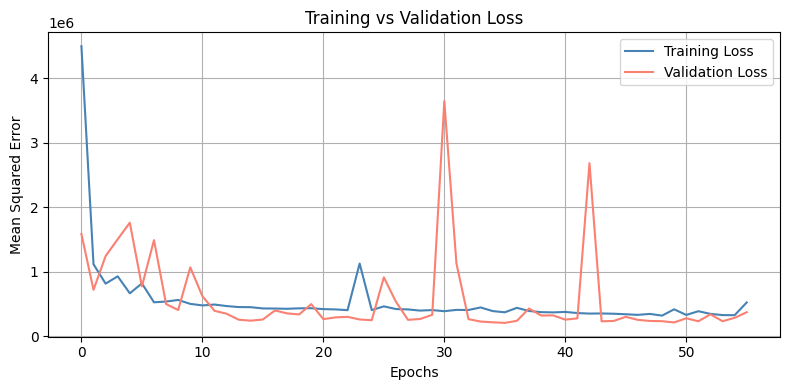

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='steelblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='salmon')
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

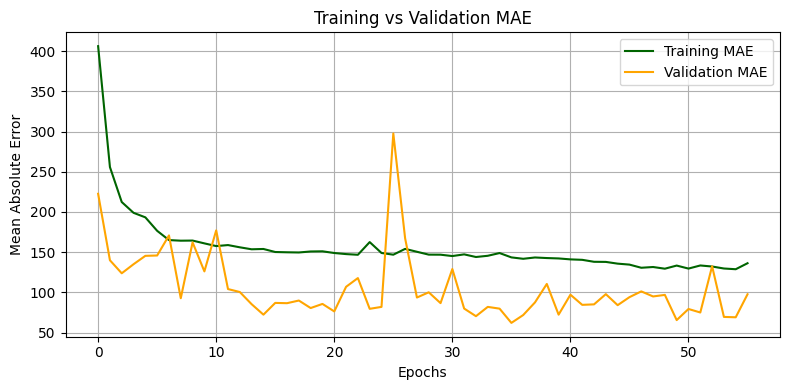

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['mae'], label='Training MAE', color='darkgreen')
plt.plot(history.history['val_mae'], label='Validation MAE', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("Training vs Validation MAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()